In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import sys
from sklearn.preprocessing import normalize

In [21]:
xy = np.loadtxt('C:\\Users\\SANHA\\Desktop\\new_data.csv', delimiter=',', dtype=np.float32)
x_data=xy[:,0:-1]
x_data = normalize(x_data, axis=0, norm='max')
xy[:,0:-1]=x_data
y_data=xy[:,[-1]]
m_data=xy[:499,:]
r_data=xy[:10000,:]
g_data=xy[:0,:]
F_data=xy[:,:]

In [3]:
# Model Inputs
def model_inputs(real_dim, noise_dim):
    inputs_real_ = tf.placeholder(tf.float32, shape=[None, real_dim], name='inputs_real')
    inputs_z_ = tf.placeholder(tf.float32, shape=[None, noise_dim], name='inputs_z')
    
    return inputs_real_, inputs_z_

def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

In [4]:
# Generator Network
def model_generator(z_input, out_dim, n_units=128, reuse=False, alpha=0.01):
    # used to reuse variables, name scope
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(z_input, n_units, activation=None)
        hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, out_dim, activation=None)
        outputs = tf.nn.sigmoid(logits)
        
        return outputs, logits

In [5]:
# Discriminator Network
def model_discriminator(input, n_units=128, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(input, n_units, activation=tf.nn.relu)
        #hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, 1, activation=None)
        outputs = tf.nn.sigmoid(logits)
        
        return outputs, logits

In [6]:
#parameter
input_size = 42
z_dim = 21
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.1
smooth = 0.1
learning_rate = 0.001

In [9]:
tf.reset_default_graph()  # If we don't have this, as we call this block over and over, the graph gets bigger and bigger

graph = tf.Graph()
with graph.as_default():
    inputs_real, inputs_z = model_inputs(input_size, z_dim)
    
    g_outputs, g_logits = model_generator(inputs_z, input_size, n_units=g_hidden_size, reuse=False, alpha=alpha)
    
    d_outputs_real, d_logits_real = model_discriminator(inputs_real, n_units=d_hidden_size, reuse=False, alpha=alpha)
    d_outputs_fake, d_logits_fake = model_discriminator(g_outputs, n_units=d_hidden_size, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    t_vars = tf.trainable_variables()
    g_vars = [variable for variable in t_vars if 'generator' in variable.name]
    d_vars = [variable for variable in t_vars if 'discriminator' in variable.name]
    
    # Affected Variables with var_list
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)
    
    # Saving variables with var_list
    saver = tf.train.Saver(var_list=g_vars)

In [7]:
plt.plot(list_loss_g,list_loss_d)

NameError: name 'list_loss_g' is not defined

In [8]:
list_loss_d

NameError: name 'list_loss_d' is not defined

In [ ]:
list_loss_g

In [11]:
samples=[]
normal=0
abnormal=0
list_loss_d=[]
list_loss_g=[]
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    f = open('C:\\Users\\SANHA\\Desktop\\gen_sample100000.txt', 'a+')
    for step in range(100000):
        
        
        batch_images = F_data[step].reshape([1, 42])
        batch_z = np.random.uniform(-1, 1, size=[1, z_dim])
        
        _ = sess.run(d_optimizer, feed_dict={inputs_real : batch_images, inputs_z : batch_z})
        _ = sess.run(g_optimizer, feed_dict={inputs_z : batch_z})
        loss_d, loss_g = sess.run([d_loss, g_loss], feed_dict={inputs_real : batch_images, inputs_z : batch_z})
        list_loss_d.append(loss_d)
        list_loss_g.append(loss_g)
        #if step%1000==0:
        #    print('step {} / {} Complete. D_Loss : {:0.3f}, G_Loss : {:0.3f}'.format(step+1, 100000, loss_d, loss_g))
        sys.stdout.write("\r%d / %d: %f, %f" % (step, 100000, loss_d, loss_g))
        sys.stdout.flush()
        sample_z = np.random.uniform(-1, 1, size=[1, z_dim])  # 16 Samples each epoch
        gen_samples, _ = sess.run(model_generator(inputs_z, input_size, reuse=True), feed_dict={inputs_z : sample_z})
        
        temp=gen_samples[0,41]
        #print(temp)
        if temp>=0.5:
            gen_samples[0,41]=1
            abnormal+=1
        else :
            gen_samples[0,41]=0
            normal+=1
        #print(temp,gen_samples[0,41])
        #write for text to csv
        f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f \n" %(gen_samples[0,0],gen_samples[0,1],gen_samples[0,2],gen_samples[0,3],gen_samples[0,4],gen_samples[0,5],gen_samples[0,6],gen_samples[0,7],gen_samples[0,8],gen_samples[0,9],gen_samples[0,10],gen_samples[0,11],gen_samples[0,12],gen_samples[0,13],gen_samples[0,14],gen_samples[0,15],gen_samples[0,16],gen_samples[0,17],gen_samples[0,18],gen_samples[0,19],gen_samples[0,20],gen_samples[0,21],gen_samples[0,22],gen_samples[0,23],gen_samples[0,24],gen_samples[0,25],gen_samples[0,26],gen_samples[0,27],gen_samples[0,28],gen_samples[0,29],gen_samples[0,30],gen_samples[0,31],gen_samples[0,32],gen_samples[0,33],gen_samples[0,34],gen_samples[0,35],gen_samples[0,36],gen_samples[0,37],gen_samples[0,38],gen_samples[0,39],gen_samples[0,40],gen_samples[0,41]))
       
        
    print('Generating Complete. normal={}, abnormal={}'.format(normal,abnormal))
    f.close()

28488 / 100000: 0.697456, 1.169728

KeyboardInterrupt: 

In [20]:
xy2 = np.genfromtxt('C:\\Users\\SANHA\\Desktop\\mix_data_40000.csv', delimiter=',', dtype=np.float32)
xy3 = np.loadtxt('C:\\Users\\SANHA\\Desktop\\gen_data.csv', delimiter=',', dtype=np.float32)
xy4 = np.loadtxt('C:\\Users\\SANHA\\Desktop\\false_data.csv', delimiter=',', dtype=np.float32)
#gen data 20000
gx_data=xy3[:,0:-1]
gy_data=xy3[:,[-1]]
gF_data=xy3[:,:]

#gen 20000+real 20000
mx_data=xy2[:39999,0:-1]
my_data=xy2[:39999,[-1]]
mF_data=xy2[:39999,:]

#real data 40000
tx_data=r_data[:40000,0:-1]
ty_data=r_data[:40000,[-1]]

#false data
FF_data=xy4[:,:]
Fx_data=xy4[:,0:-1]
Fy_data=xy4[:,[-1]]
print("finished")

finished


step:     0	Loss: 0.645	Acc: 54.81%


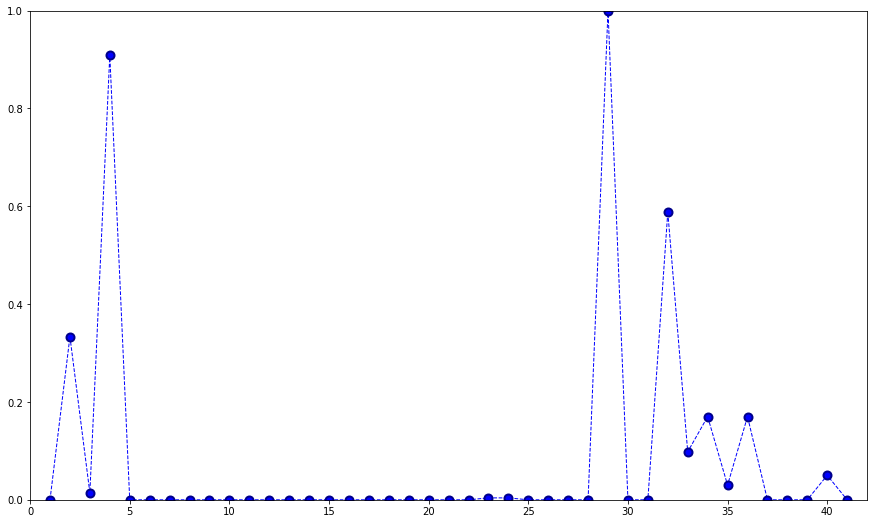

step:     1	Loss: 0.578	Acc: 79.00%


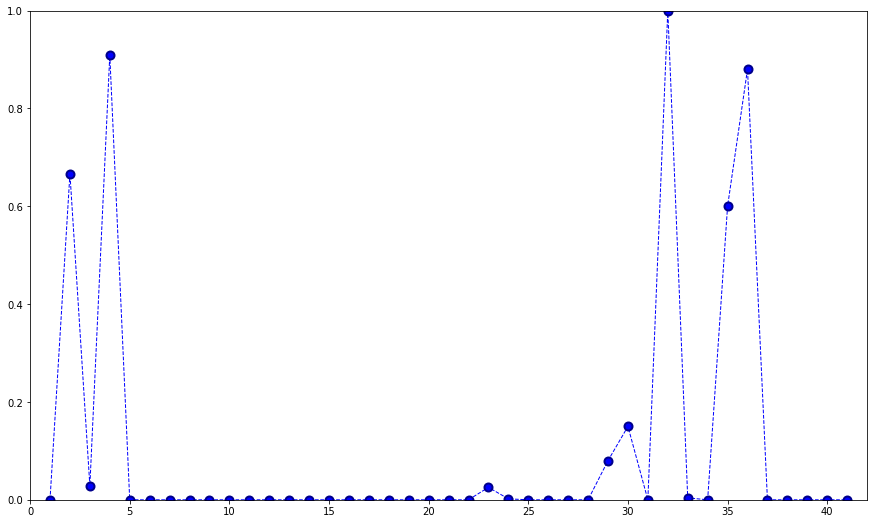

step:     2	Loss: 0.532	Acc: 79.53%


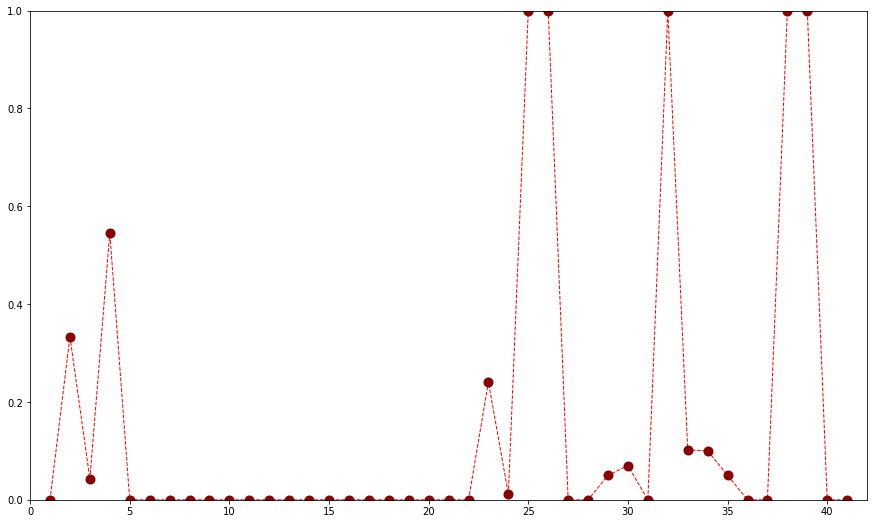

step:     3	Loss: 0.444	Acc: 82.00%


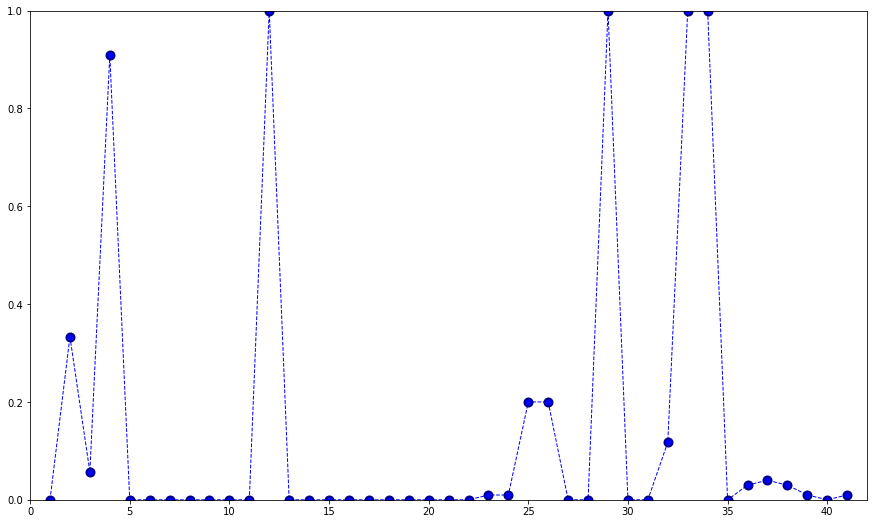

step:     4	Loss: 0.356	Acc: 86.81%


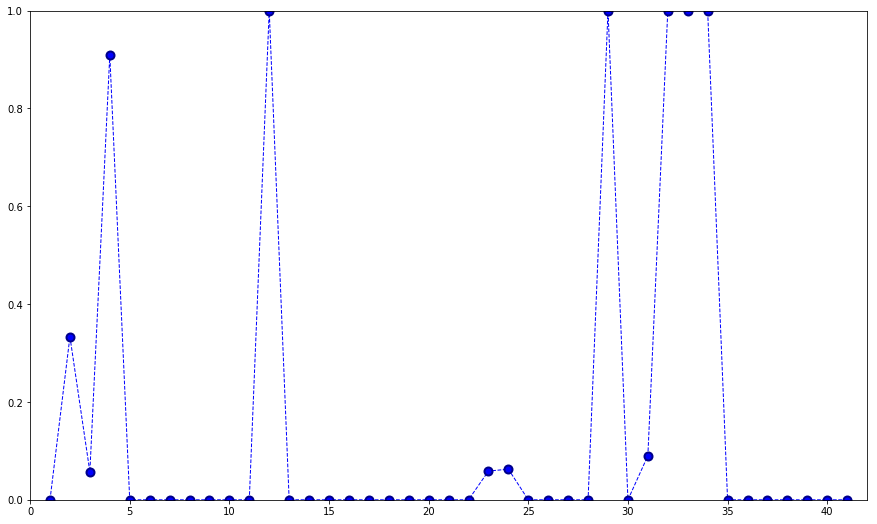

step:     5	Loss: 0.299	Acc: 87.69%


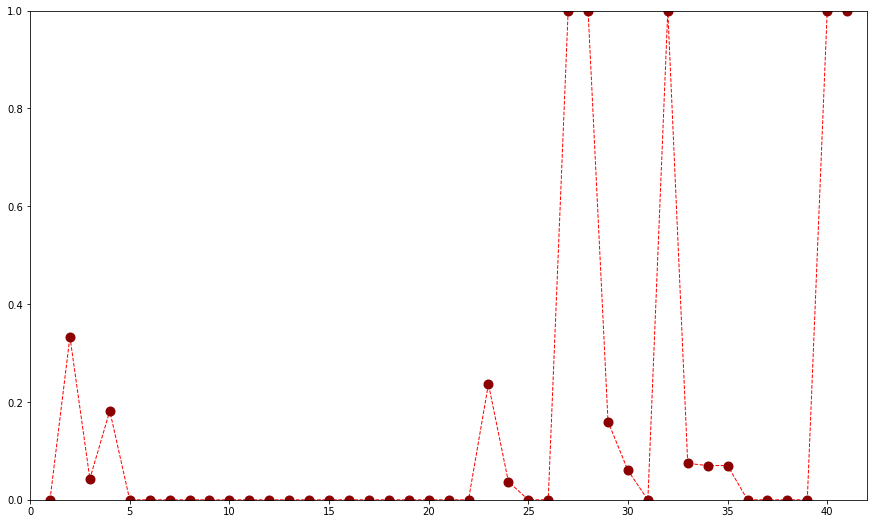

step:     6	Loss: 0.275	Acc: 89.24%


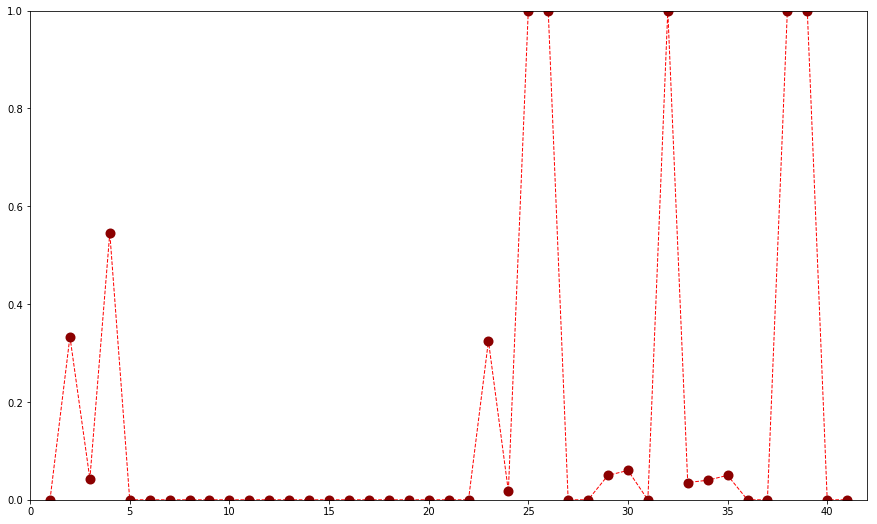

step:     7	Loss: 0.270	Acc: 89.70%


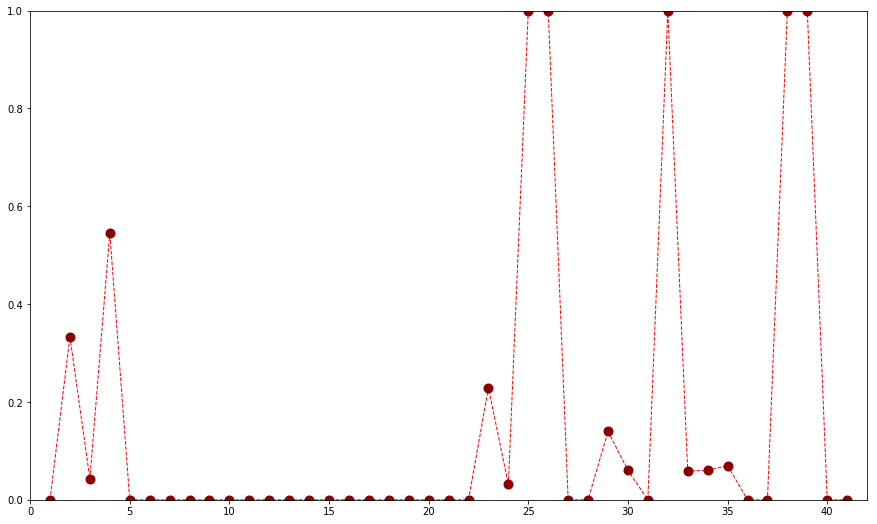

step:     8	Loss: 0.269	Acc: 90.24%


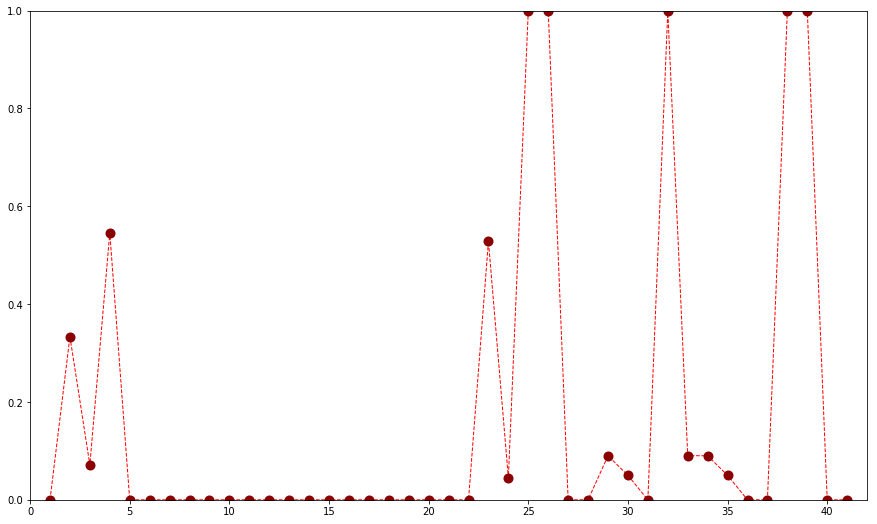

step:     9	Loss: 0.264	Acc: 90.57%


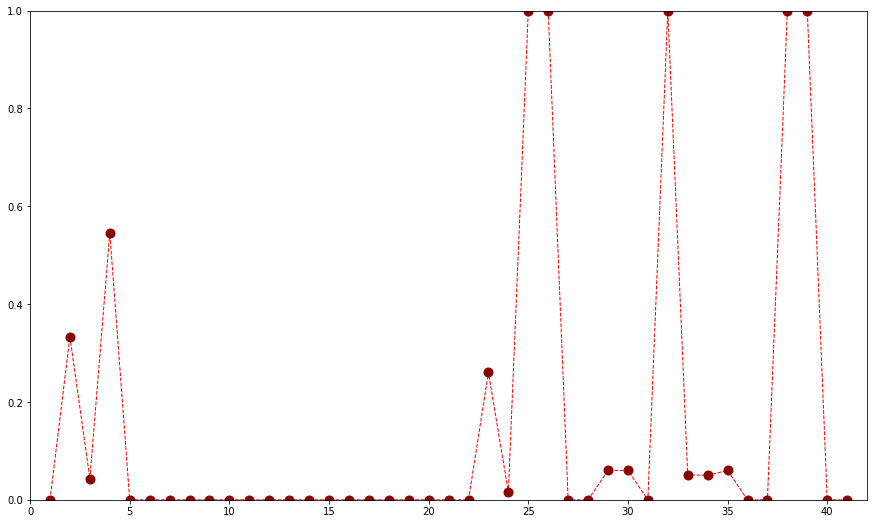

step:    10	Loss: 0.252	Acc: 90.61%


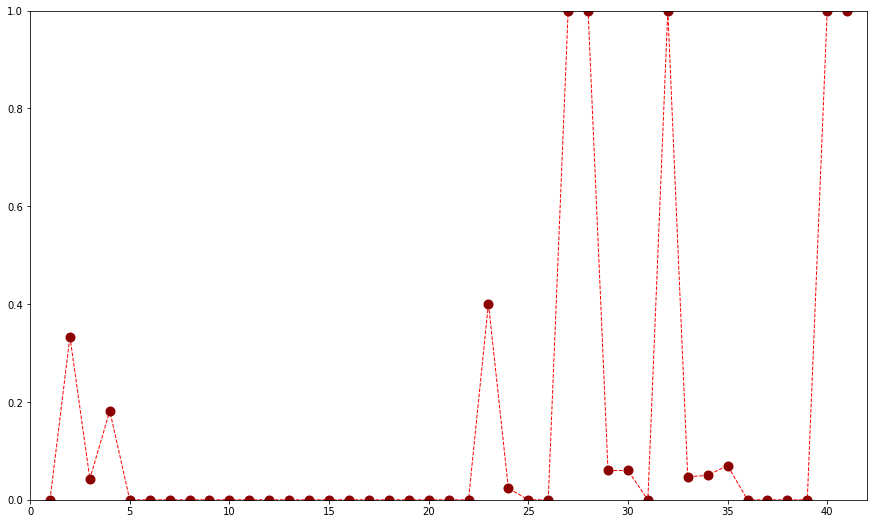

step:    11	Loss: 0.236	Acc: 90.47%


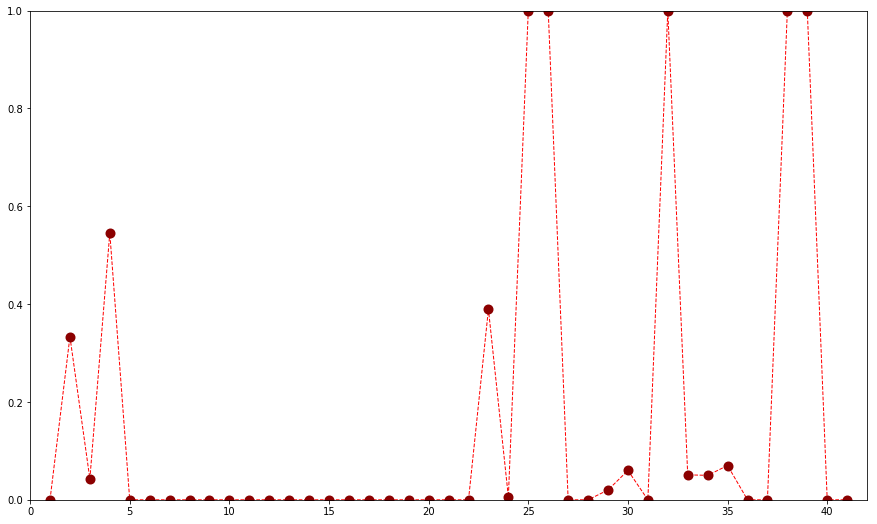

step:    12	Loss: 0.220	Acc: 90.37%


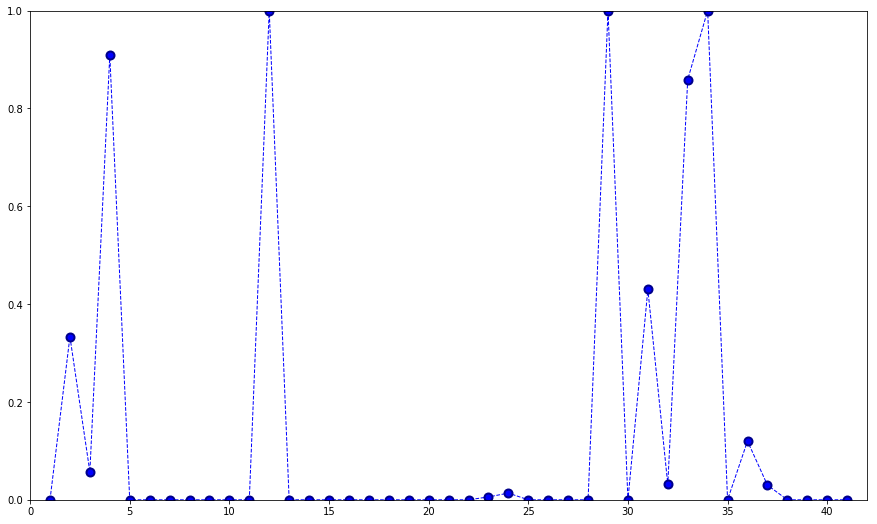

step:    13	Loss: 0.207	Acc: 90.49%


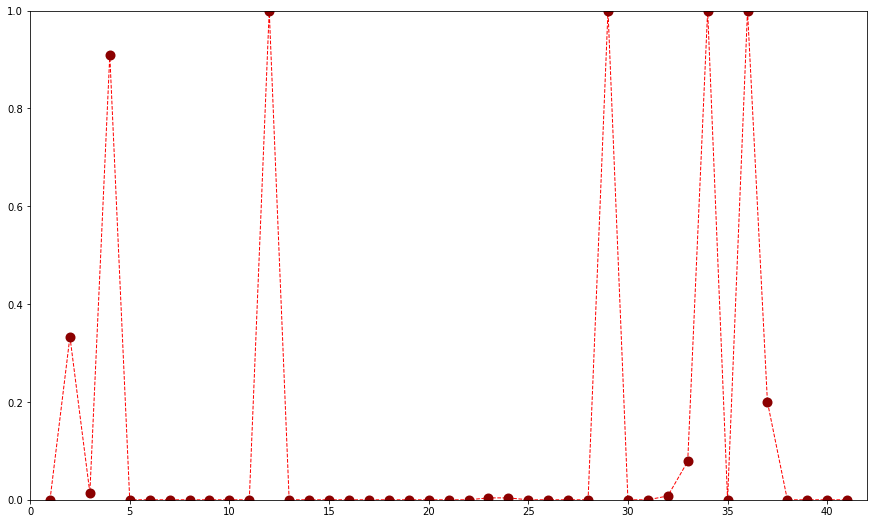

step:    14	Loss: 0.199	Acc: 90.69%


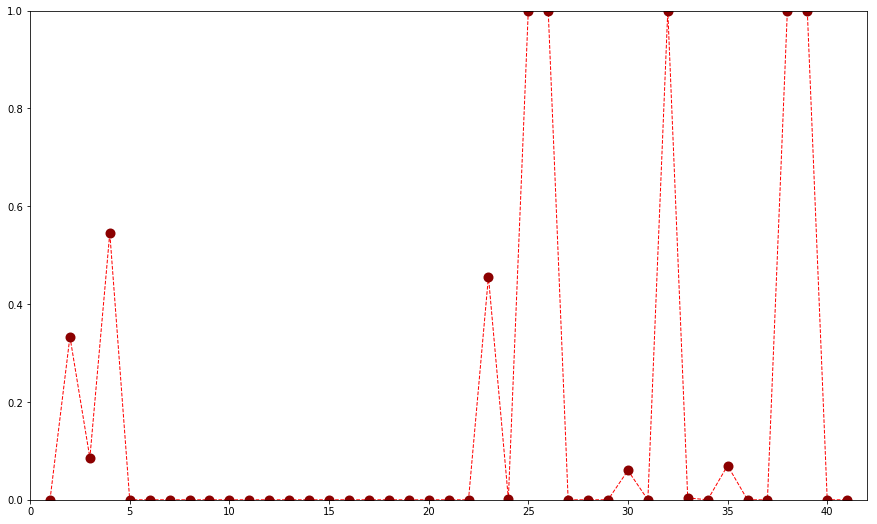

step:    15	Loss: 0.194	Acc: 91.58%


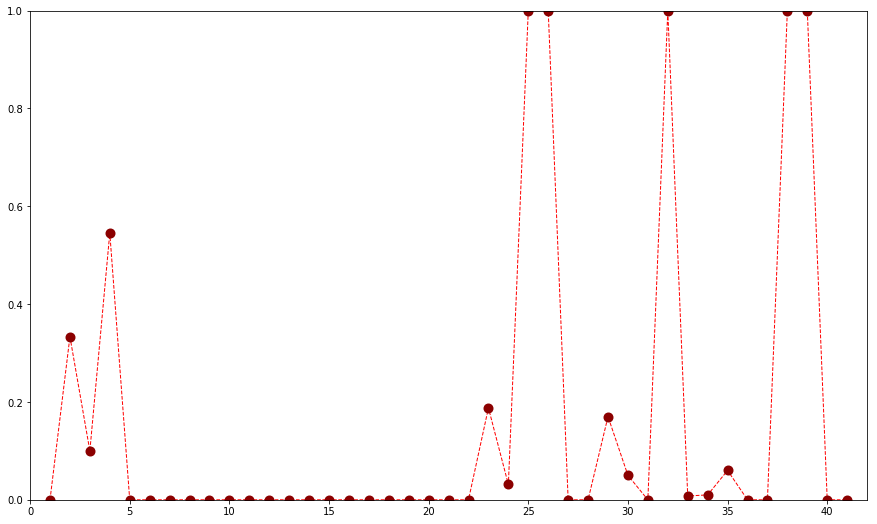

step:    16	Loss: 0.192	Acc: 92.31%


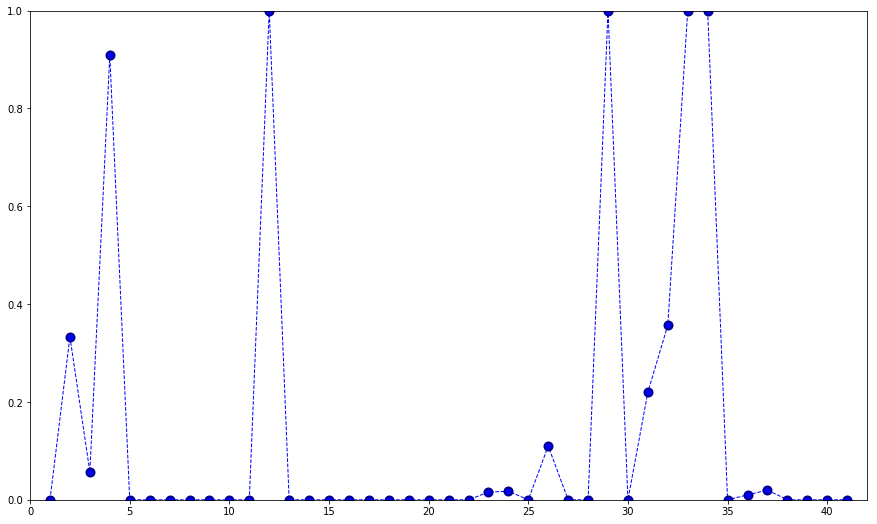

step:    17	Loss: 0.191	Acc: 92.40%


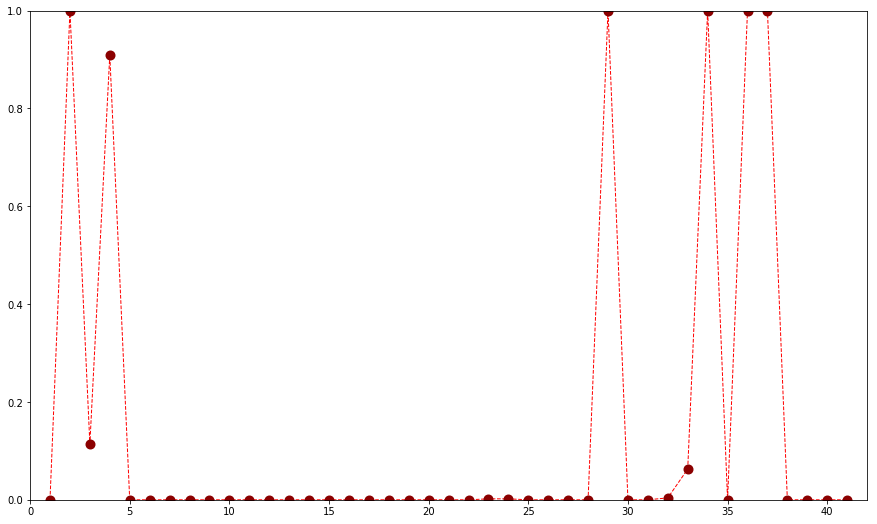

step:    18	Loss: 0.190	Acc: 92.44%


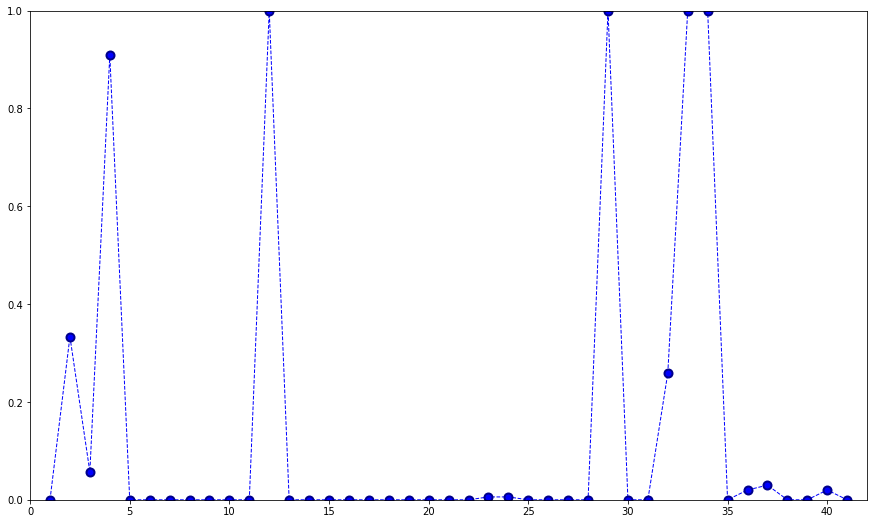

step:    19	Loss: 0.187	Acc: 92.36%


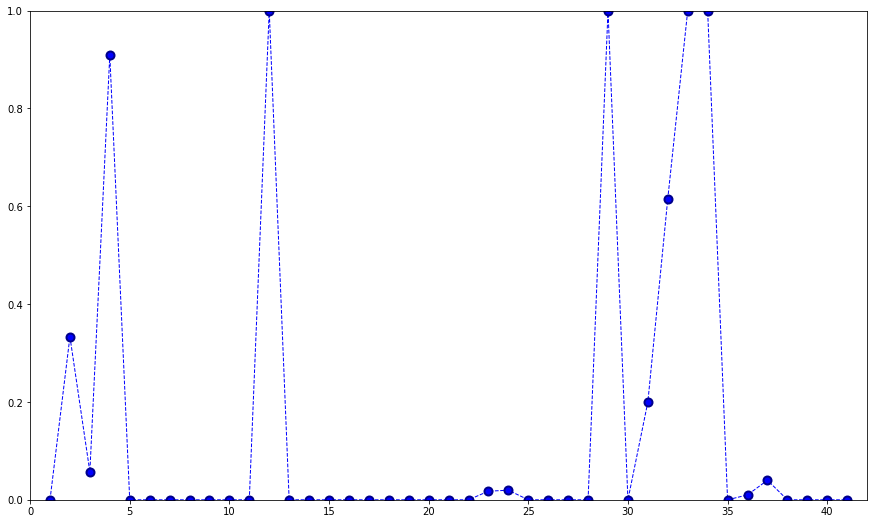

step:    20	Loss: 0.183	Acc: 92.49%


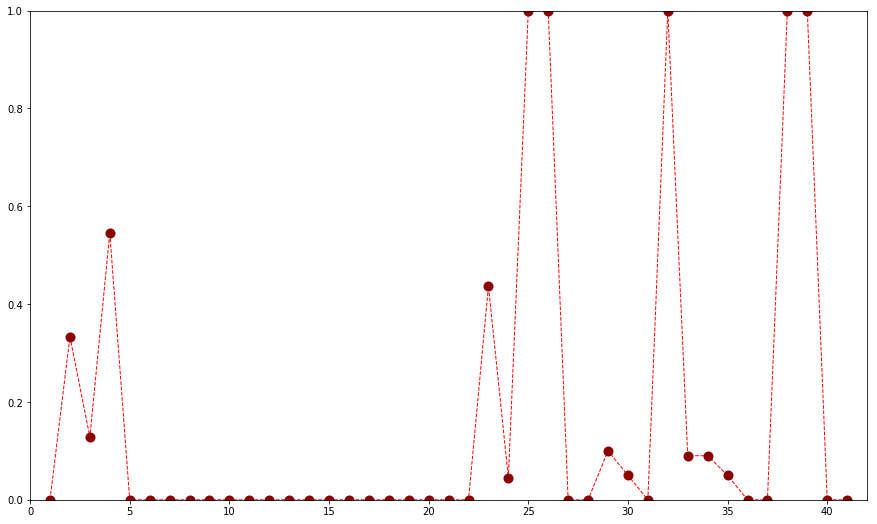

step:    21	Loss: 0.177	Acc: 92.80%


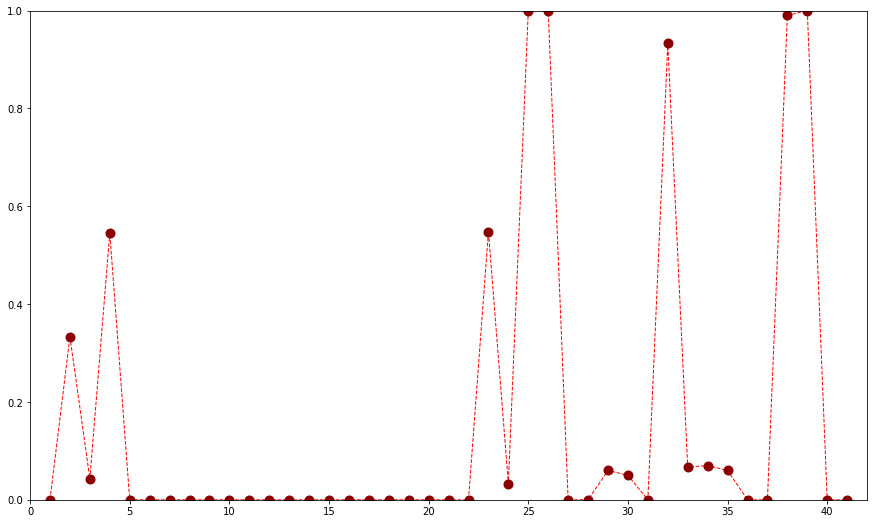

step:    22	Loss: 0.171	Acc: 93.37%


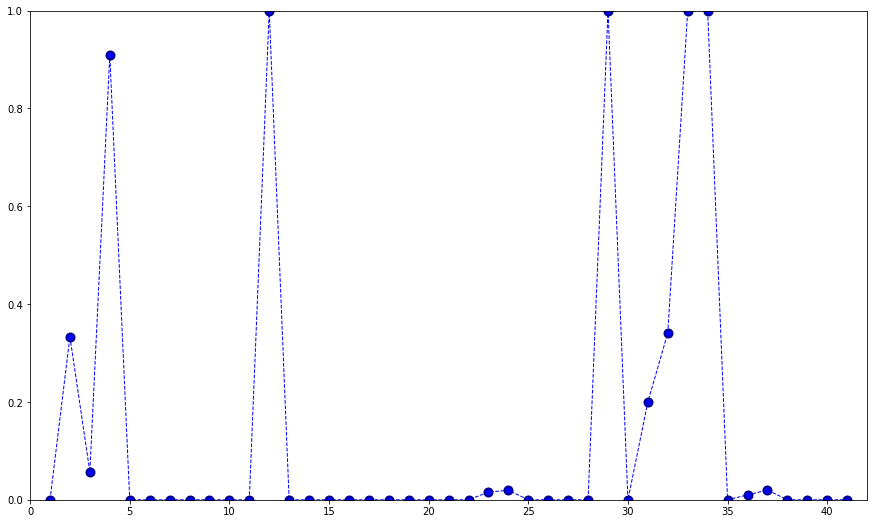

step:    23	Loss: 0.166	Acc: 93.91%


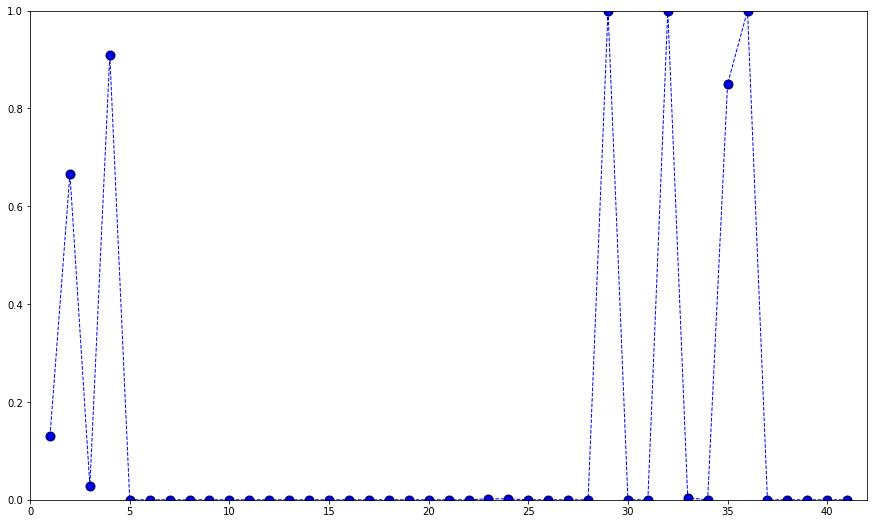

step:    24	Loss: 0.162	Acc: 94.02%


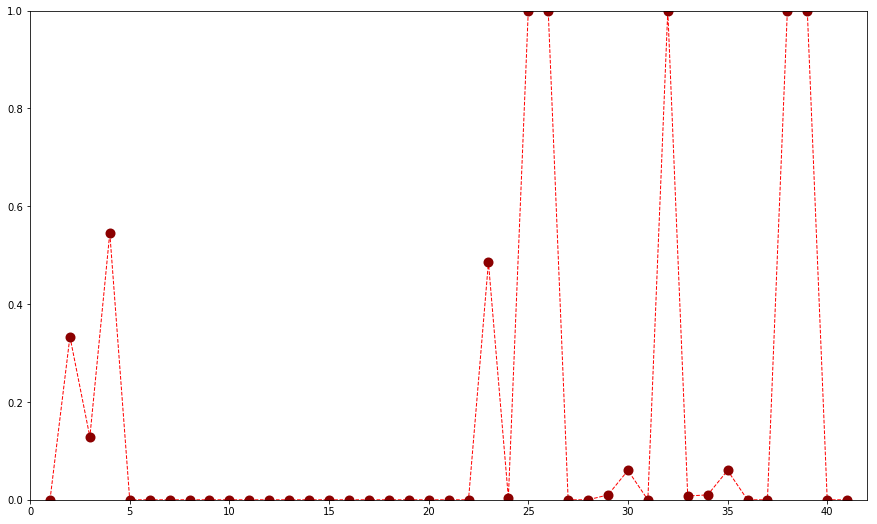

step:    25	Loss: 0.159	Acc: 94.08%


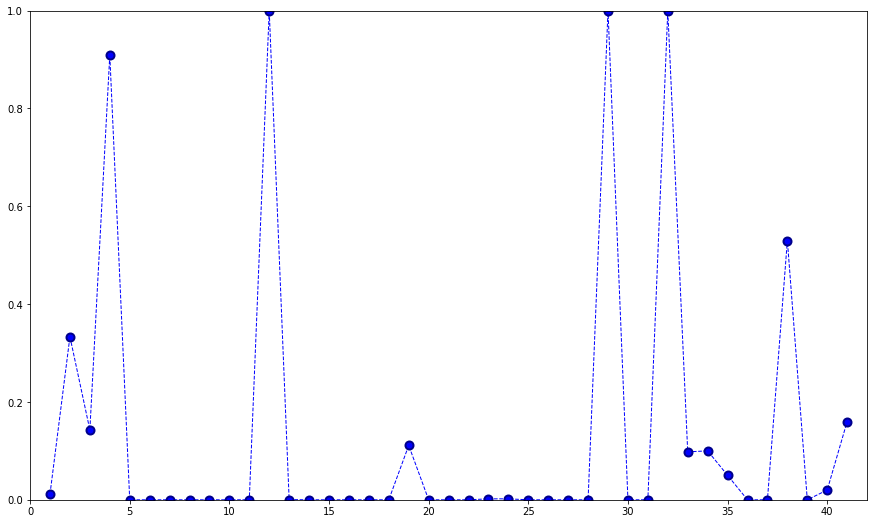

step:    26	Loss: 0.157	Acc: 94.33%


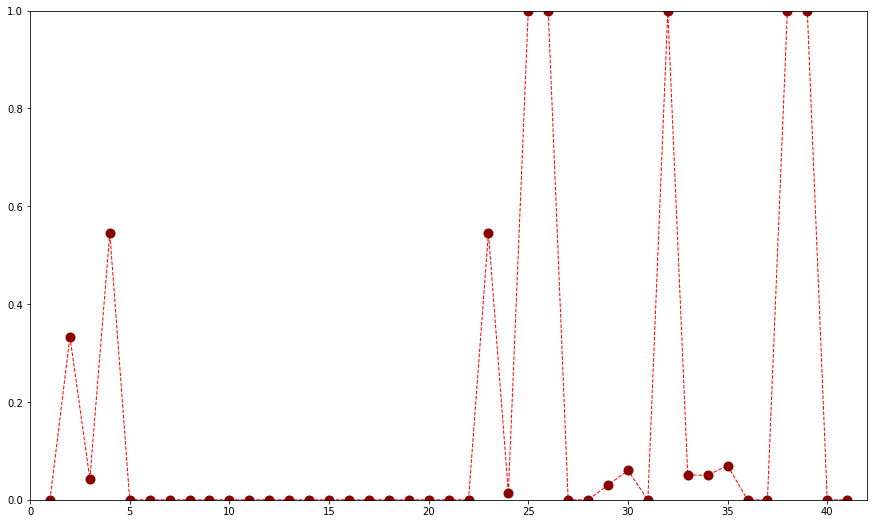

step:    27	Loss: 0.156	Acc: 94.56%


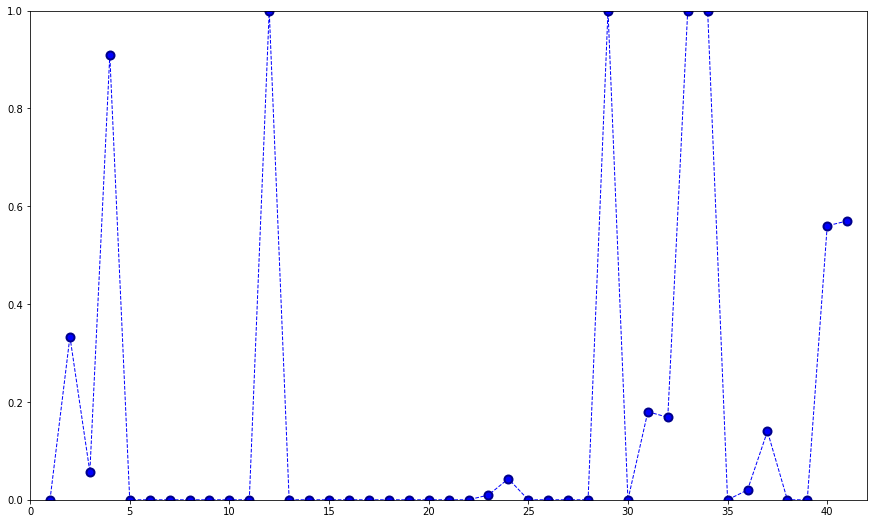

step:    28	Loss: 0.154	Acc: 94.81%


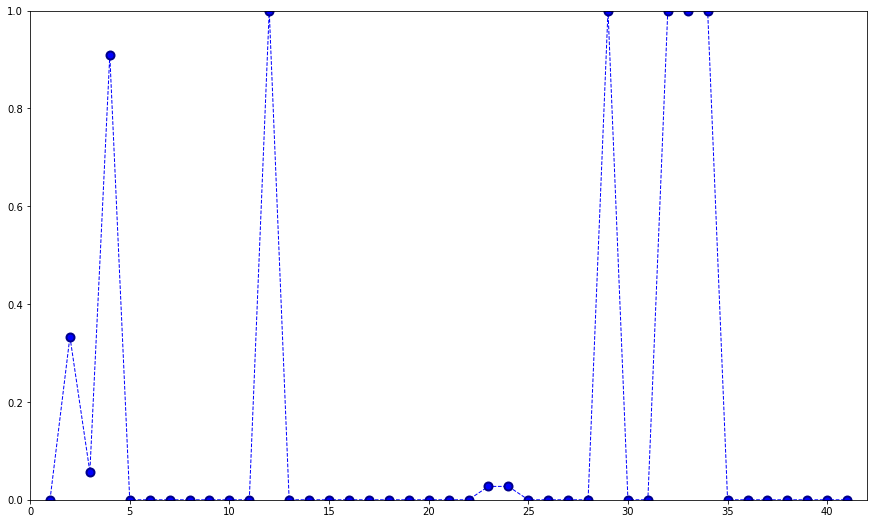

step:    29	Loss: 0.152	Acc: 95.11%


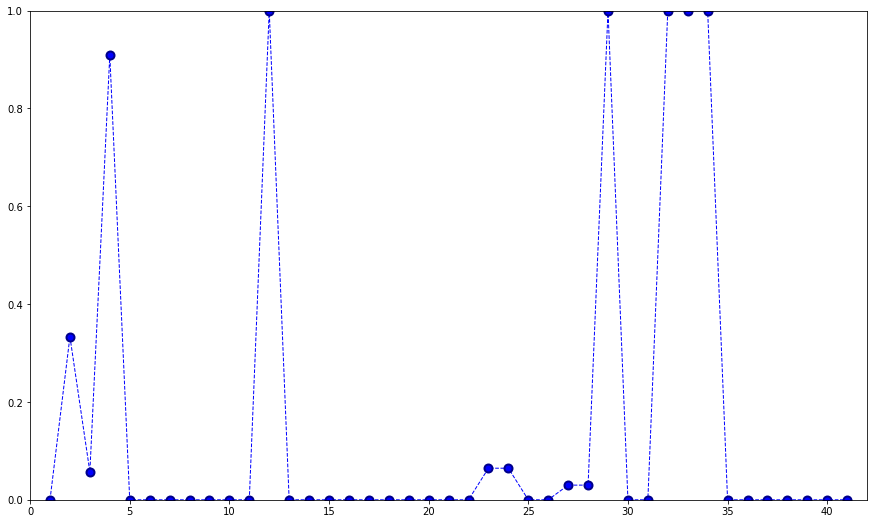

step:    30	Loss: 0.150	Acc: 95.31%


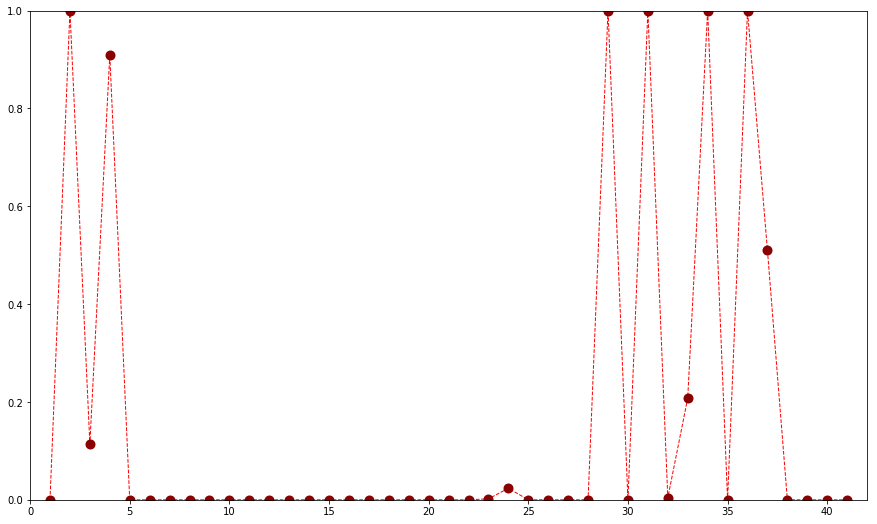

step:    31	Loss: 0.147	Acc: 95.33%


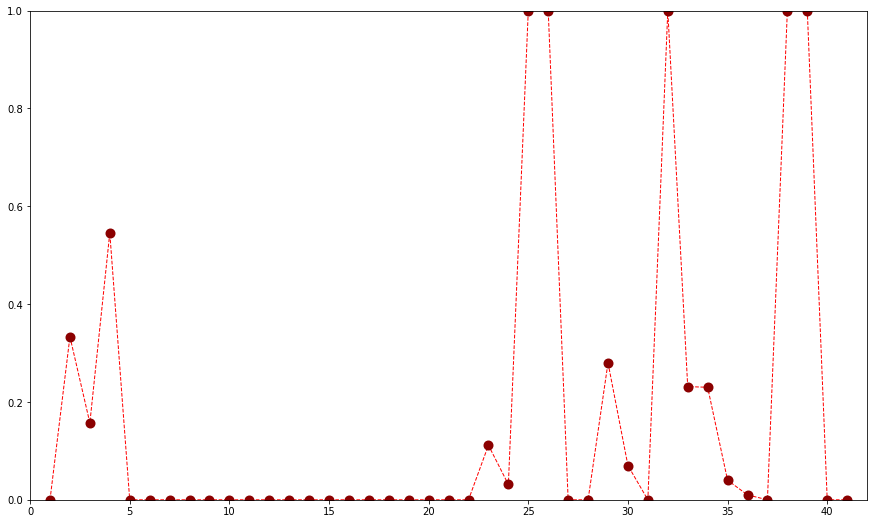

step:    32	Loss: 0.144	Acc: 95.26%


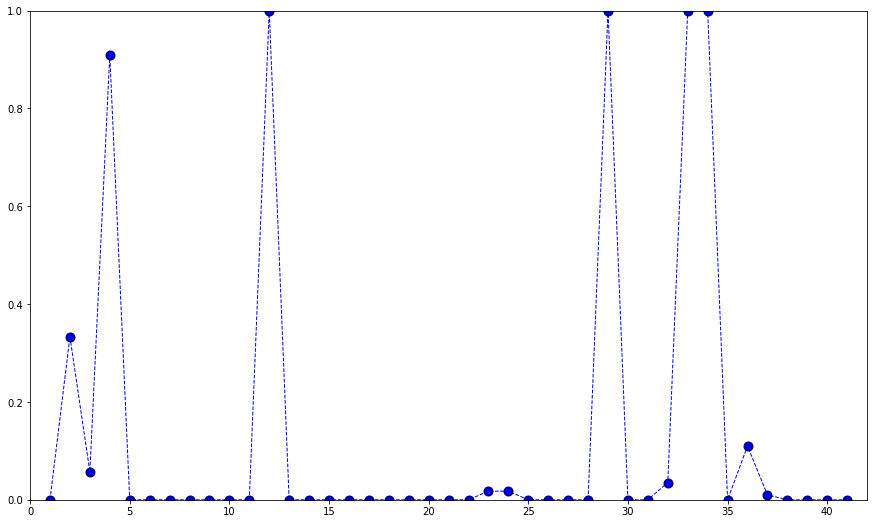

step:    33	Loss: 0.142	Acc: 95.15%


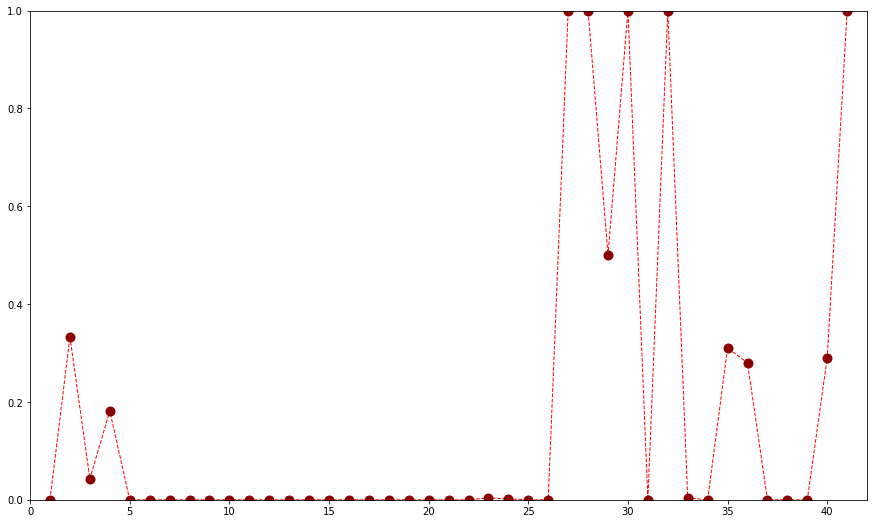

step:    34	Loss: 0.140	Acc: 95.03%


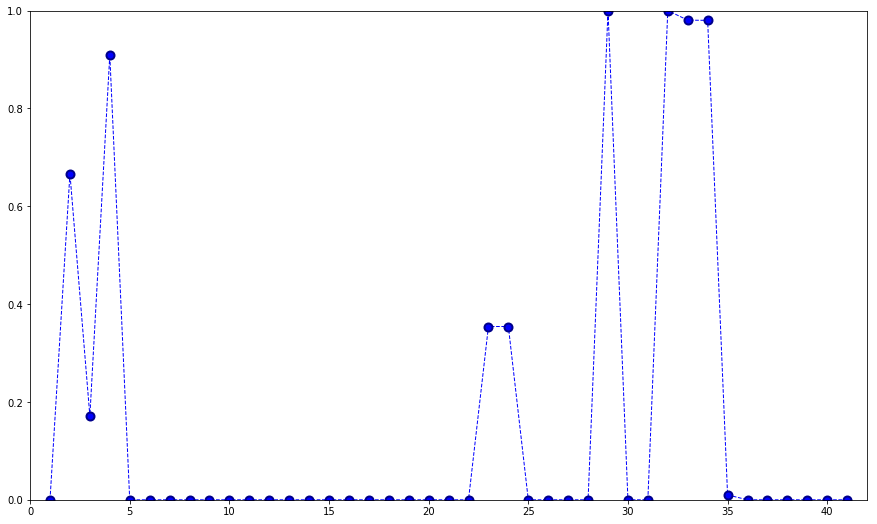

step:    35	Loss: 0.139	Acc: 94.85%


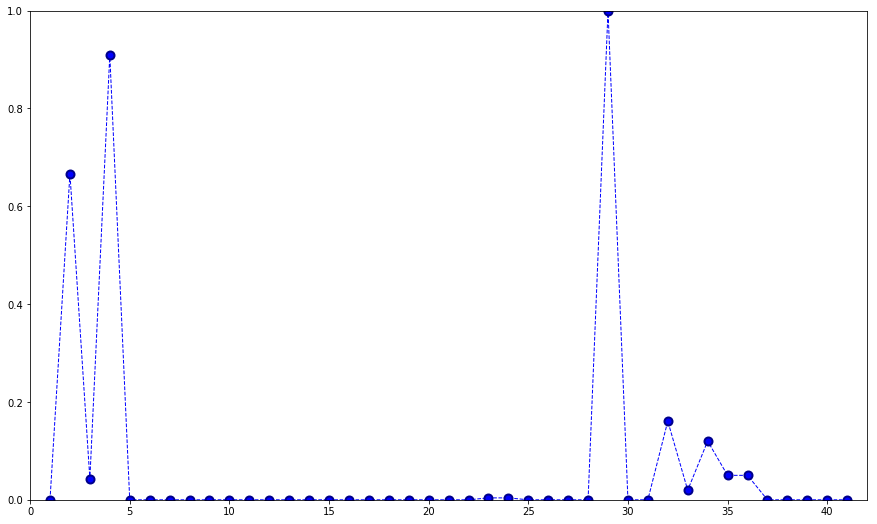

step:    36	Loss: 0.138	Acc: 94.78%


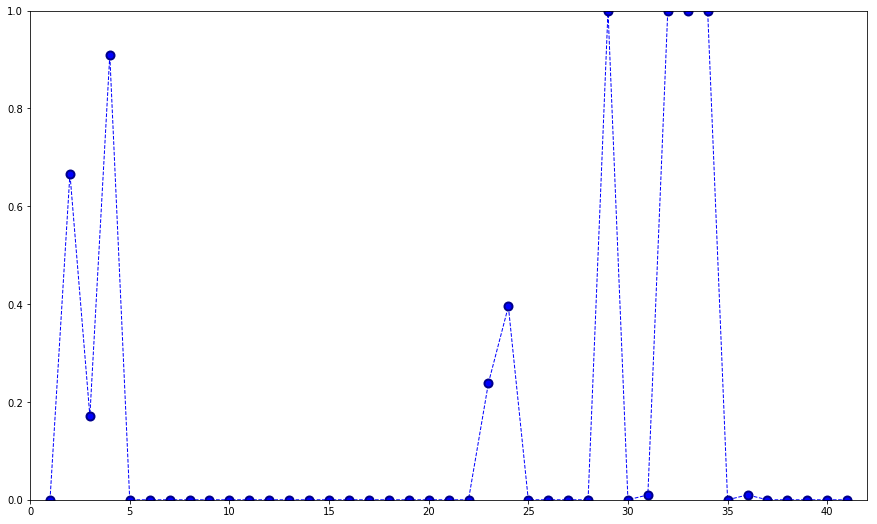

step:    37	Loss: 0.137	Acc: 94.75%


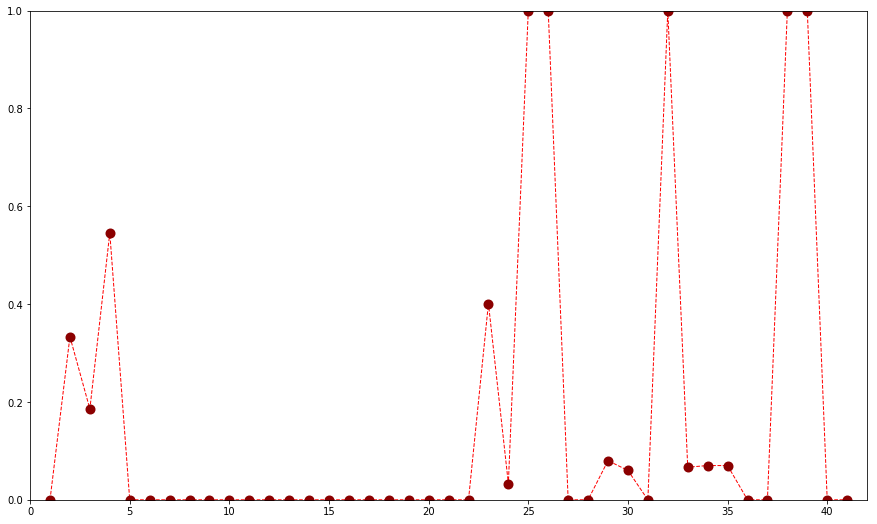

step:    38	Loss: 0.135	Acc: 94.81%


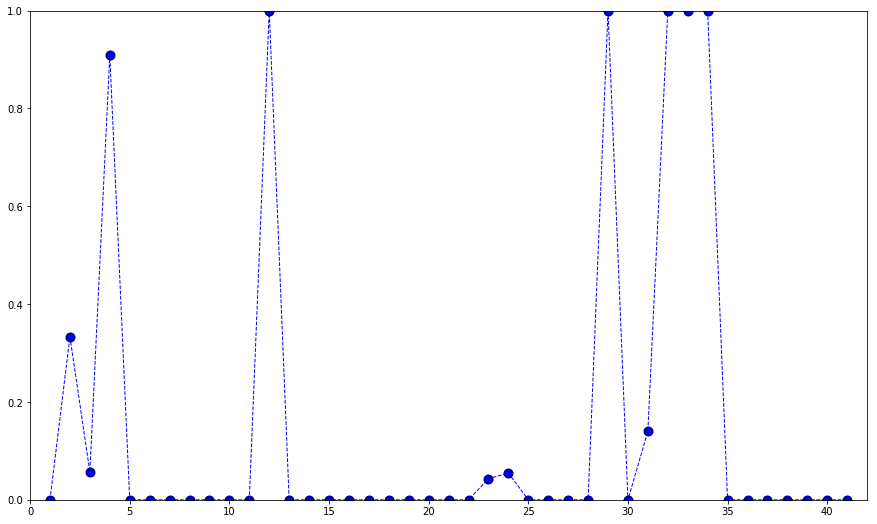

step:    39	Loss: 0.134	Acc: 95.03%


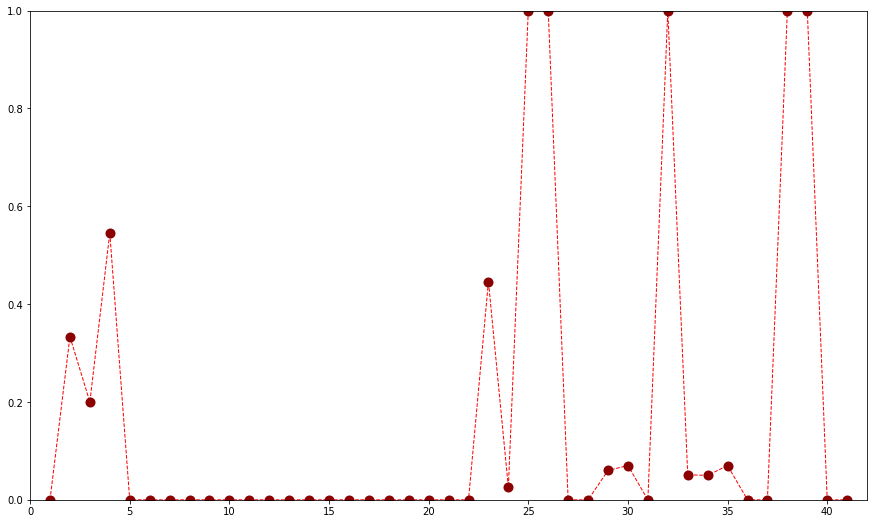

step:    40	Loss: 0.133	Acc: 95.48%


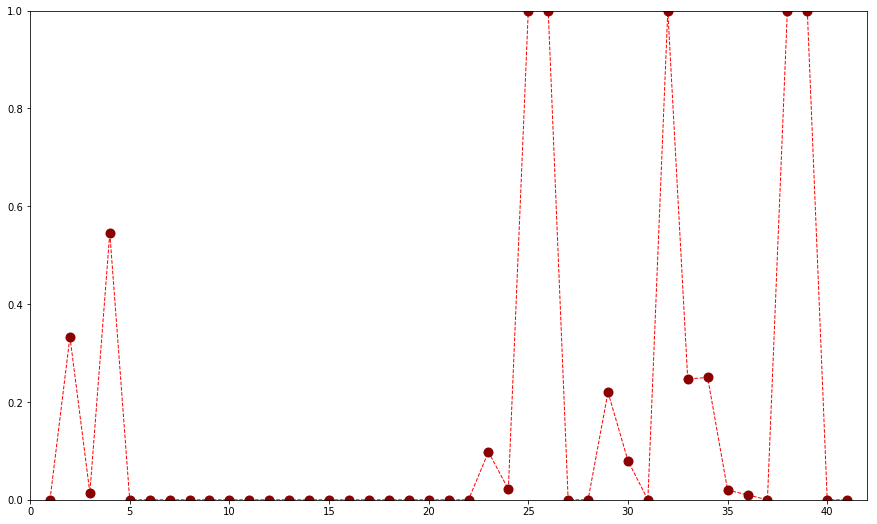

step:    41	Loss: 0.131	Acc: 95.70%


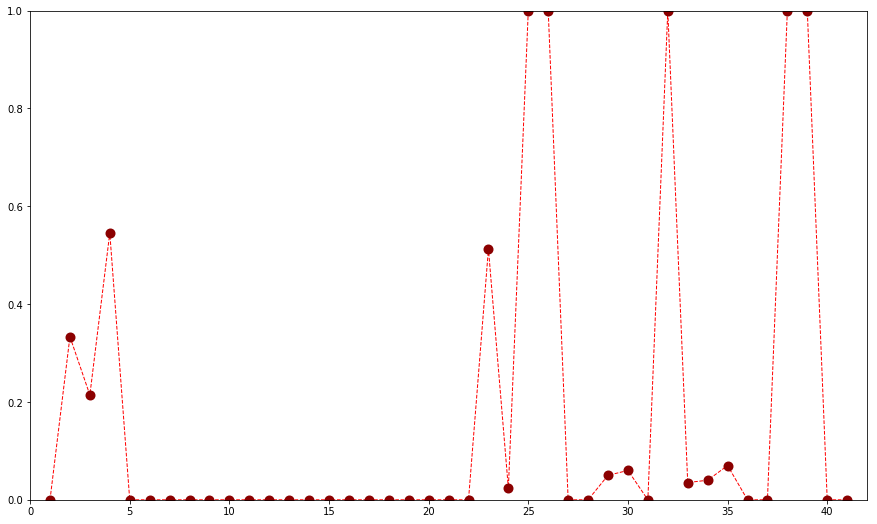

step:    42	Loss: 0.130	Acc: 95.80%


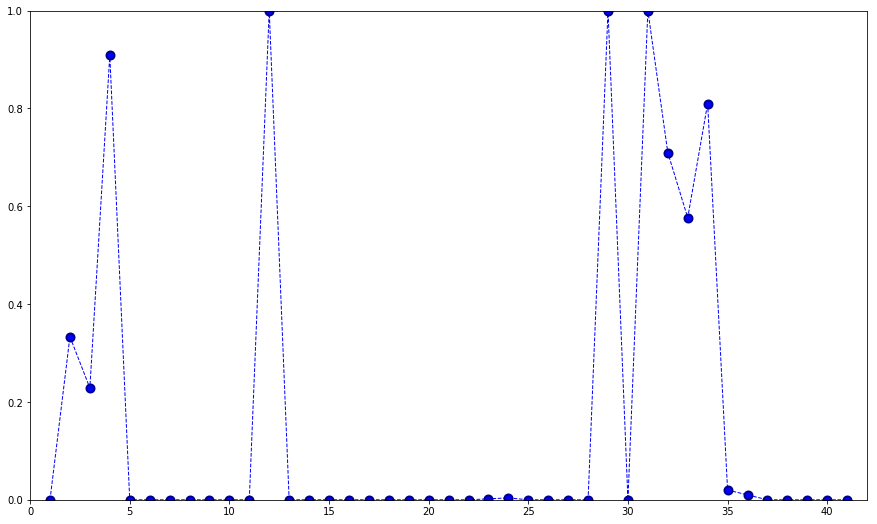

step:    43	Loss: 0.128	Acc: 95.95%


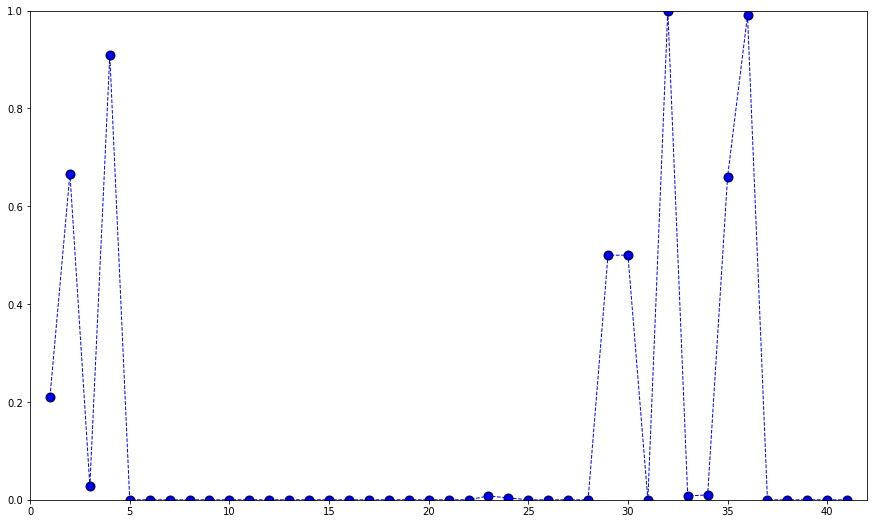

step:    44	Loss: 0.127	Acc: 96.10%


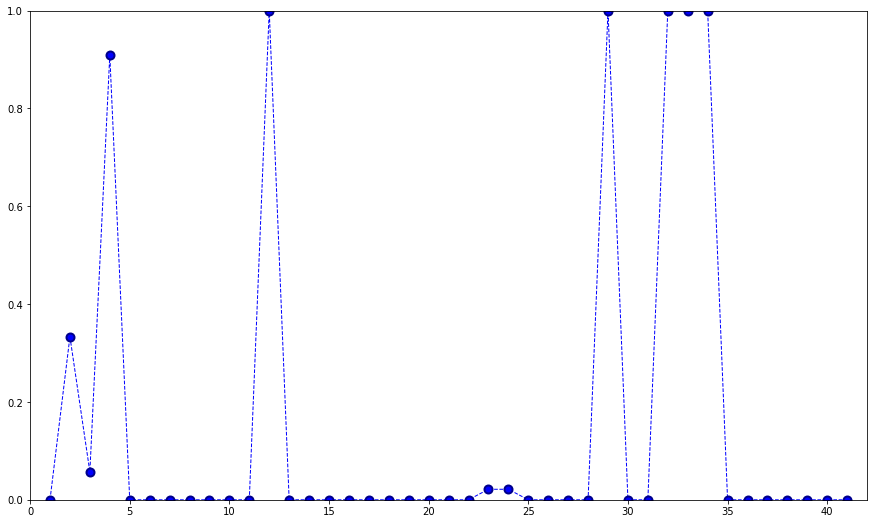

step:    45	Loss: 0.127	Acc: 96.19%


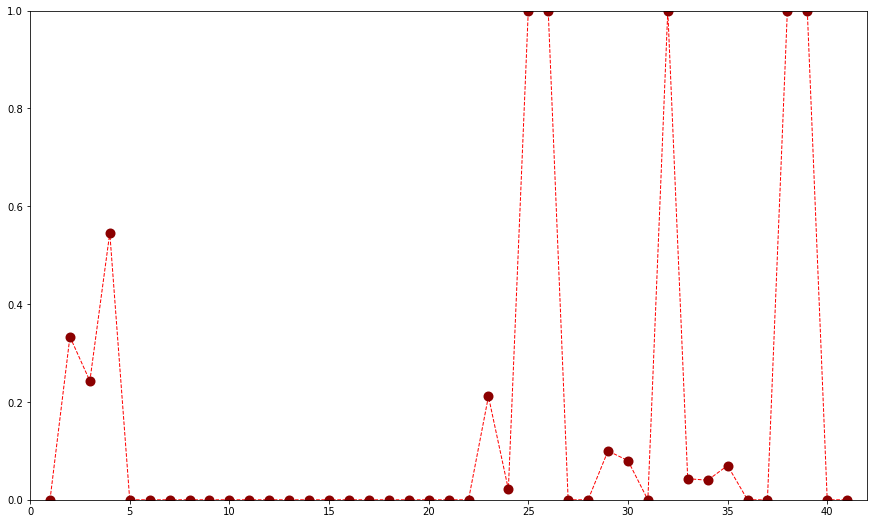

step:    46	Loss: 0.126	Acc: 96.23%


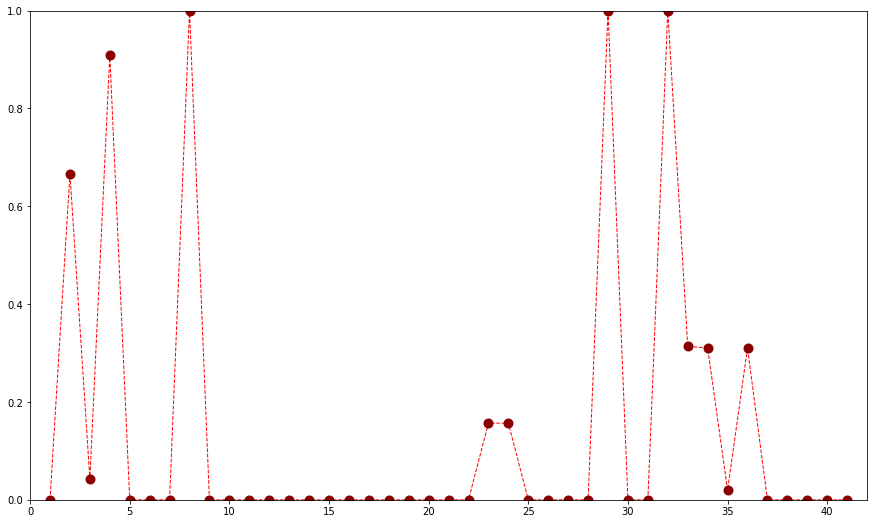

step:    47	Loss: 0.125	Acc: 96.24%


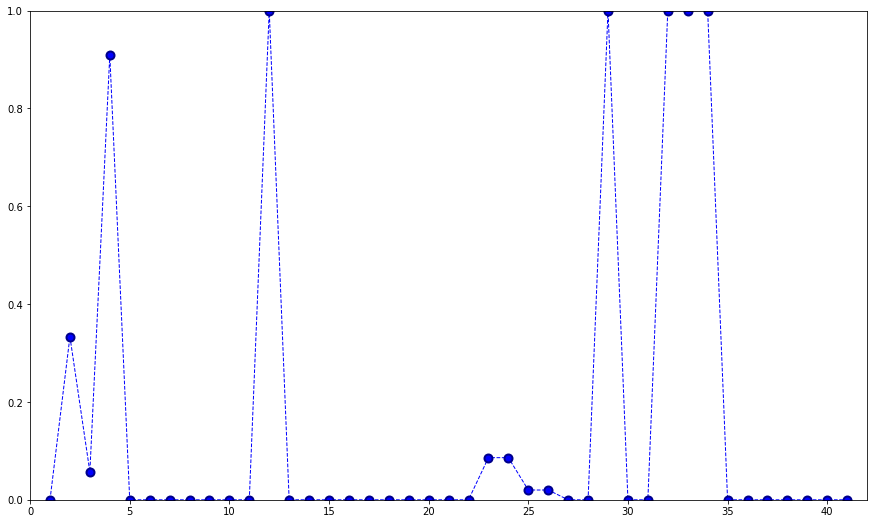

step:    48	Loss: 0.124	Acc: 96.23%


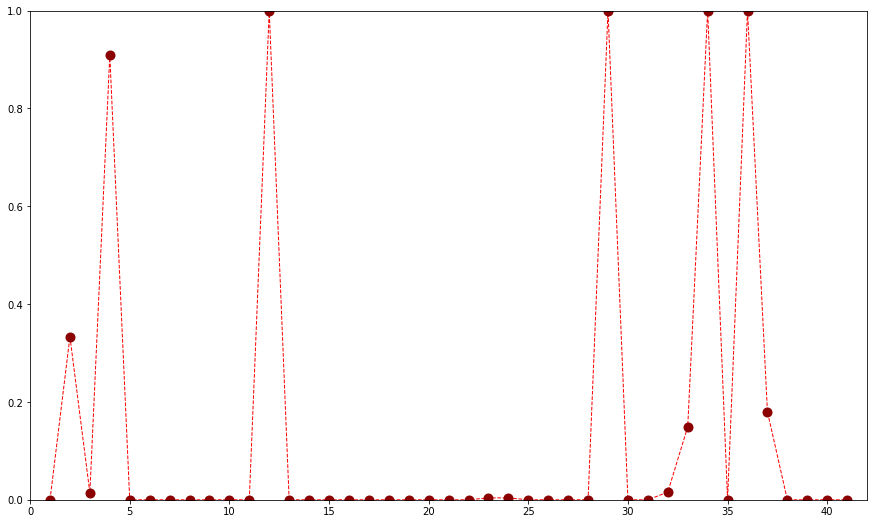

step:    49	Loss: 0.123	Acc: 96.20%


KeyboardInterrupt: 

In [143]:

nb_classes=2

X=tf.placeholder(tf.float32,[None,41])
Y=tf.placeholder(tf.int32,[None,1])

Y_one_hot=tf.one_hot(Y,nb_classes)
Y_one_hot=tf.reshape(Y_one_hot,[-1,nb_classes])

W1=tf.Variable(tf.random_normal([41,41]),name='weight1')
b1=tf.Variable(tf.random_normal([41]),name='bias1')
layer1=tf.sigmoid(tf.matmul(X,W1)+b1)

W2=tf.Variable(tf.random_normal([41,41]),name='weight2')
b2=tf.Variable(tf.random_normal([41]),name='bias2')
layer2=tf.sigmoid(tf.matmul(layer1,W2)+b2)

W3=tf.Variable(tf.random_normal([41,nb_classes]),name='weight3')
b3=tf.Variable(tf.random_normal([nb_classes]),name='bias3')
logits=tf.matmul(layer2,W3)+b3
hypothesis=tf.nn.softmax(logits)

cost_i=tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=Y_one_hot)

cost=tf.reduce_mean(cost_i)
optimizer=tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

prediction=tf.argmax(hypothesis,1) #가능성을 퍼센트로~~
correct_prediction=tf.equal(prediction,tf.arg_max(Y_one_hot,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    f = open('C:\\Users\\SANHA\\Desktop\\false_data.txt', 'a+')
    for step in range(1000):
        sess.run(optimizer,feed_dict={X:x_data,Y:y_data})
        #print("training by gan sample")
        if step %1==0:
            loss,acc=sess.run([cost,accuracy],feed_dict={X:x_data,Y:y_data})
            print("step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
            fig = plt.figure(figsize=(15,9))
            ax = fig.add_subplot(1,1,1)
            ax.set(xlim=[0, 42], ylim=[0,1])

            line, = ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41], x_data[step,:].flatten())
           
            if(y_data[step,:]==0):
                line.set(color='blue',
                     linewidth=1, linestyle='--',
                     marker='o', markersize=8, markeredgewidth=2,
                     markerfacecolor='blue', markeredgecolor='darkblue')
            else:
                line.set(color='red',
                     linewidth=1, linestyle='--',
                     marker='o', markersize=8, markeredgewidth=2,
                     markerfacecolor='darkred', markeredgecolor='darkred')

            plt.show()            
              
    tr=0
    fa=0
    total=0
#m_data=np.append(m_data,gen_samples,axis=0)

    pred = sess.run(prediction, feed_dict={X: x_data})
    for p, y in zip(pred, y_data.flatten()):
            if(p==int(y)):
                tr=tr+1
            else:
                fa=fa+1
                #print(gx_data)
                f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f \n" %(gx_data[fa,0],gx_data[fa,1],gx_data[fa,2],gx_data[fa,3],gx_data[fa,4],gx_data[fa,5],gx_data[fa,6],gx_data[fa,7],gx_data[fa,8],gx_data[fa,9],gx_data[fa,10],gx_data[0,11],gx_data[fa,12],gx_data[fa,13],gx_data[fa,14],gx_data[fa,15],gx_data[fa,16],gx_data[fa,17],gx_data[fa,18],gx_data[fa,19],gx_data[fa,20],gx_data[fa,21],gx_data[fa,22],gx_data[fa,23],gx_data[fa,24],gx_data[fa,25],gx_data[fa,26],gx_data[fa,27],gx_data[fa,28],gx_data[fa,29],gx_data[fa,30],gx_data[fa,31],gx_data[fa,32],gx_data[fa,33],gx_data[fa,34],gx_data[fa,35],gx_data[fa,36],gx_data[fa,37],gx_data[fa,38],gx_data[fa,39],gx_data[fa,40],gy_data[fa,0]))
                
            #print("[{}] Prediction: {} Real Y: {}".format(p == int(y), p, int(y)))
    f.close()
    print("true={} false: {} acc: {:0.2f}".format(tr,fa,tr/(tr+fa)))
    
    

In [ ]:
with tf.Session() as sess:  
    pred = sess.run(prediction, feed_dict={X: x_data})
    for p, y in zip(pred, y_data.flatten()):
            if(p==int(y)):
                tr=tr+1
            else:
                fa=fa+1
                #print(gx_data)
                f.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f \n" %(gx_data[fa,0],gx_data[fa,1],gx_data[fa,2],gx_data[fa,3],gx_data[fa,4],gx_data[fa,5],gx_data[fa,6],gx_data[fa,7],gx_data[fa,8],gx_data[fa,9],gx_data[fa,10],gx_data[0,11],gx_data[fa,12],gx_data[fa,13],gx_data[fa,14],gx_data[fa,15],gx_data[fa,16],gx_data[fa,17],gx_data[fa,18],gx_data[fa,19],gx_data[fa,20],gx_data[fa,21],gx_data[fa,22],gx_data[fa,23],gx_data[fa,24],gx_data[fa,25],gx_data[fa,26],gx_data[fa,27],gx_data[fa,28],gx_data[fa,29],gx_data[fa,30],gx_data[fa,31],gx_data[fa,32],gx_data[fa,33],gx_data[fa,34],gx_data[fa,35],gx_data[fa,36],gx_data[fa,37],gx_data[fa,38],gx_data[fa,39],gx_data[fa,40],gy_data[fa,0]))
                
            #print("[{}] Prediction: {} Real Y: {}".format(p == int(y), p, int(y)))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

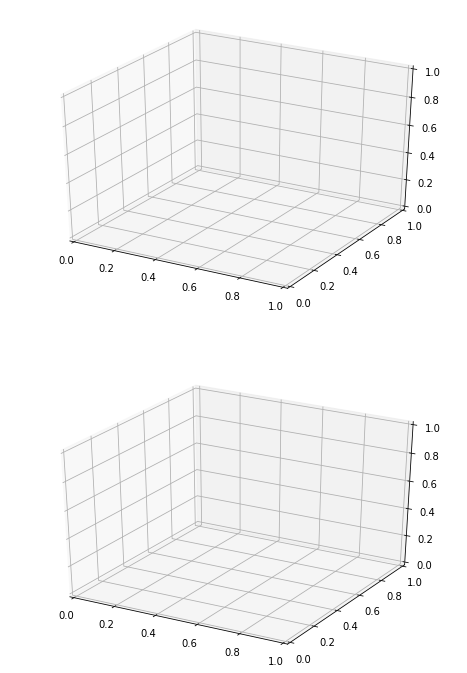

In [34]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
graph=F_data[:100,:]

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 12), subplot_kw={'projection': '3d'})

# Get the test data
#X, Y, Z = axes3d.get_test_data(0.05)
X=graph[:100,:-1]
Y=graph[:100,[-1]]
Z=graph[:100,:-1]
# Give the first plot only wireframes of the type y = c
ax1.plot_wireframe(X, Y, Z, rstride=10, cstride=0)
ax1.set_title("Column (x) stride set to 0")

# Give the second plot only wireframes of the type x = c
ax2.plot_wireframe(X, Y, Z, rstride=0, cstride=10)
ax2.set_title("Row (y) stride set to 0")

plt.tight_layout()
plt.show()


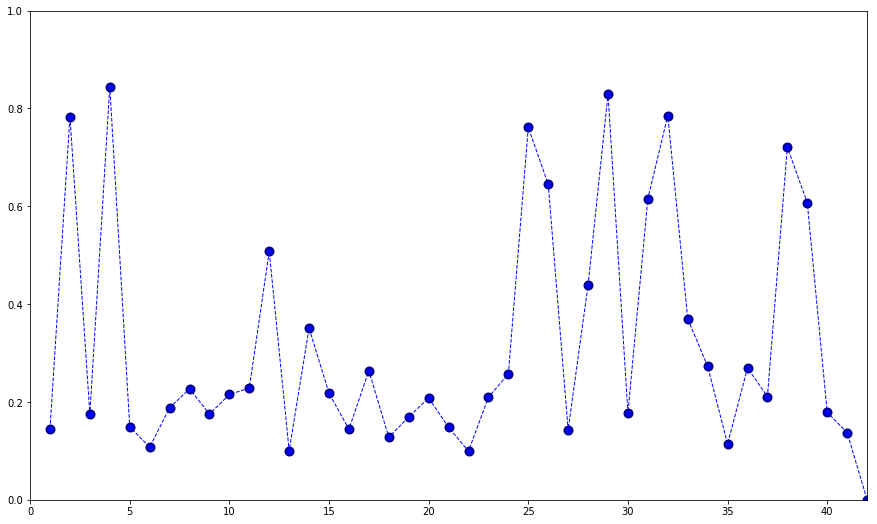

In [129]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.set(xlim=[0, 42], ylim=[0,1])
 
line, = ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42], FF_data[99:100,:].flatten())
if(FF_data[99:100,[-1]]==0):
    line.set(color='blue',
         linewidth=1, linestyle='--',
         marker='o', markersize=8, markeredgewidth=2,
         markerfacecolor='blue', markeredgecolor='darkblue')
else:
    line.set(color='red',
         linewidth=1, linestyle='--',
         marker='o', markersize=8, markeredgewidth=2,
         markerfacecolor='blue', markeredgecolor='darkred')
 
plt.show()

